In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import sys
import time
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/cifar10-comp/sample_submission.csv
/kaggle/input/cifar10-comp/train_images.npy
/kaggle/input/cifar10-comp/train_labels.csv
/kaggle/input/cifar10-comp/test_images.npy


### Data preparation and augmentation after its loading

In [ ]:
# constants ....
batch_size = 64 # samples per batch
num_workers = 48 #number of subprocesses to use for data loading
valid_percentage = .20


# CifarDataset is a class that construct a dataset out of training images
# stored as numpy arrays and its corresponding training labels - also
# stored as numpy arrays
# This CifarDataset class serves also to provide testing images converted
# Tensors in a way that they can be provided via a DataLoader
class CifarDataset(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data)
        self.target = target if target is None else torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else ""
        if self.transform:
            x = self.transform(x.numpy())

        if self.target is None:
            return x
        else:
            return x, y

    def __len__(self):
        return len(self.data)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# loading the images and training labels
test_images  = np.load('/input/cifar10-comp/test_images.npy')
train_images = np.load('/input/cifar10-comp/train_images.npy')
train_labels = pd.read_csv('/input/cifar10-comp/train_labels.csv')
train_labels = pd.Series(train_labels['Category'])

# we need to correctly  transpose the numpy arrays, so
# they can be converted to PIL images later while they are being
# drawn from the data loaders
train_images = train_images.transpose([0,2,3,1])
test_images = test_images.transpose([0,2,3,1])

train_int_labels = np.array([]) # numpy array where the training labels are going to be stored as integer value
for x in train_labels:
    train_int_labels = np.append(train_int_labels, [classes.index(x)])


# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# define transformations for the test images, which means only converting them to
# Tensors and normalizing them
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating the cifar dataset
x_train = CifarDataset(train_images, train_int_labels, transform=transform)
x_test  = CifarDataset(test_images, transform=test_transform)

# training indices to be used for validation purposes
indices = list(range(len(x_train)))
# split the training dataset into a -real- training dataset and a validation set
np.random.shuffle(indices)
split = int(np.floor(len(x_train) * valid_percentage)) # we take 24 percent of the training dataset for validation
train_indices, valid_indices = indices[split:], indices[:split]

# define samplers - they sample/obtain batches from a list of indices.
# batches are built out of random sampled elements
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# prepare loaders
train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
# the following test loader is used to load all the test images into the model for their classification
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, num_workers=num_workers)

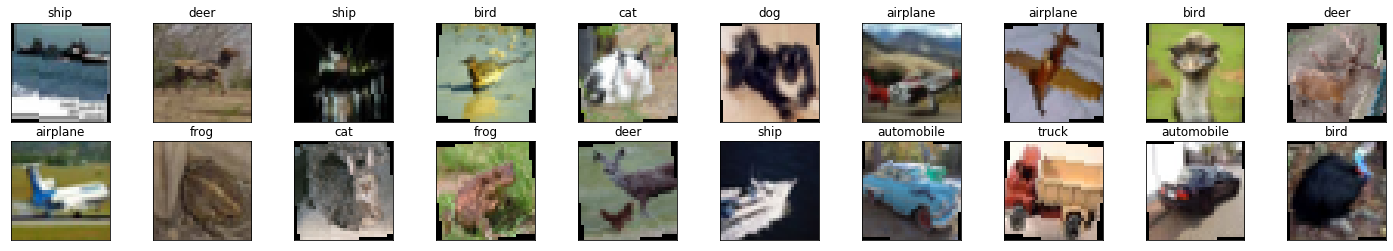

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def showImage(img):
    img = img / 2 + 0.5 # unnormalize the picture
    plt.imshow(np.transpose(img, (1,2,0))) # convert from Tensor image



# get a batch of training images
dataiterator = iter(train_loader)
images, labels = dataiterator.next()
images = images.numpy() # convert images to numpy for display

# plot the iamges of the batch
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    showImage(images[i])
    ax.set_title(classes[labels[i]])

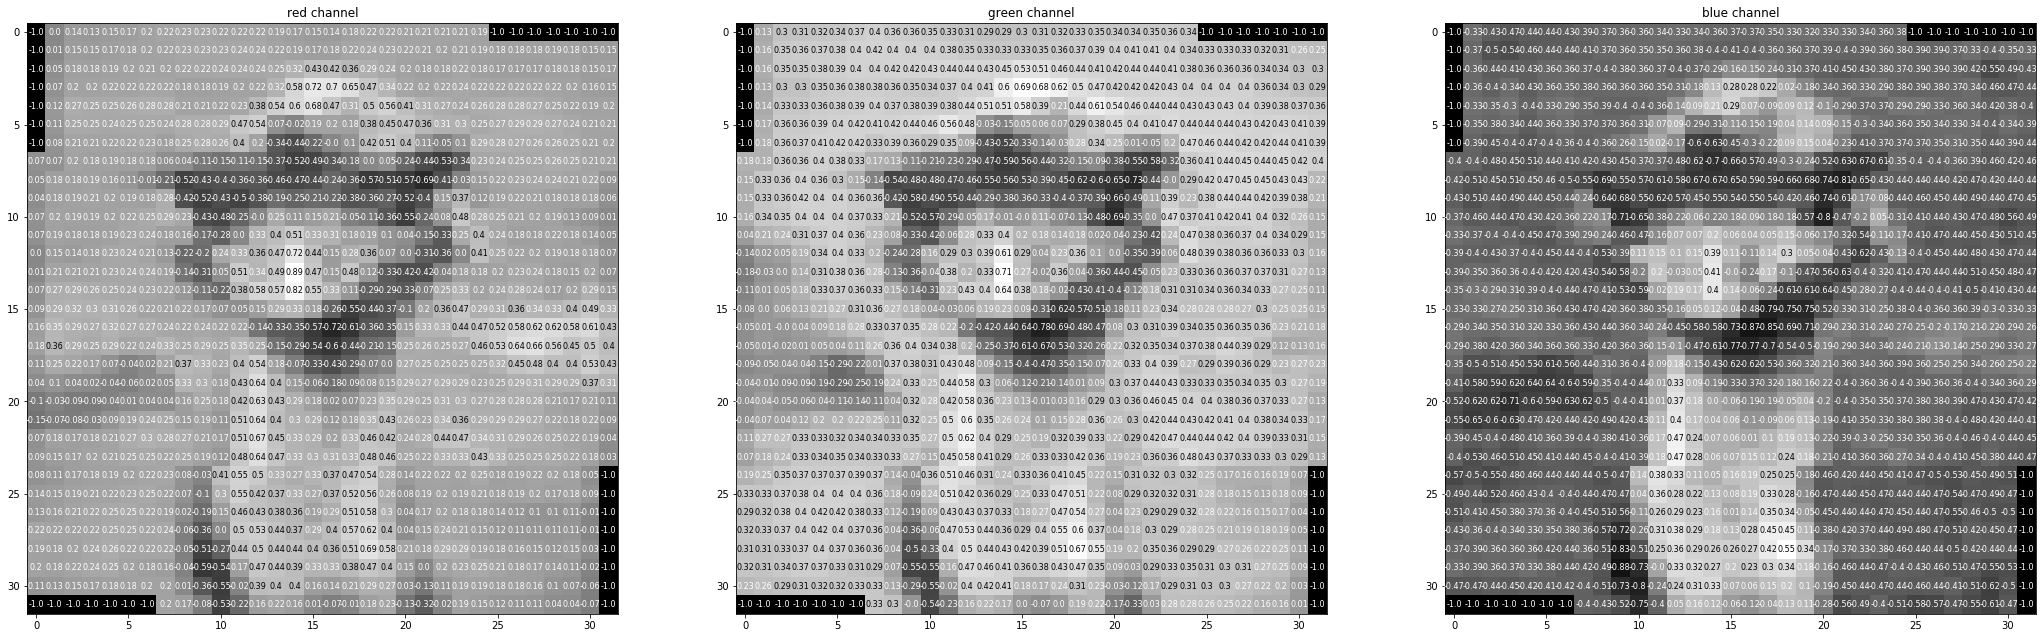

In [ ]:
rgb_img = np.squeeze(images[8])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## My DenseNet implementation (DenseNet class)

### My DenseNet implementation.

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, nLayers, tlayer="Bottleneck", k=32, compression_factor=0.5, nClasses=100):
        super(DenseNet, self).__init__()

        # validate parameters...
        nLayers, layer, self.compression_factor = self.__Validate_params(nLayers, tlayer, compression_factor)

        # create the main sequentail module
        self.densenet = nn.Sequential()

        # Before entering the first dense block, a convolution with 16 (or twice the growth rate for DenseNet-BC)
        # ouput channels is performed on the input images.
        preprocess_outmaps = 2 * k if (layer is self.__Bottleneck and self.compression_factor < 1.) else 16
        self.densenet.add_module("preprocessInput", nn.Conv2d(3, preprocess_outmaps, kernel_size=3, stride=1, padding=1, padding_mode='zeros', bias=True))

        # create the dense blocks according to the size of the 'nLayers' list
        # I define - for clarity/readability reasons - a 'innerChanns' variable whose
        # value is initialized to 'preprocess_outmaps'
        innerChanns = preprocess_outmaps

        for indx in range(len(nLayers) - 1): # we skip here the creation of the last dense block ....

            # build a dense block with the number of layers according
            # to the index 'indx' of the 'nLayers' list
            locals()['DenseBlock_{}'.format(indx)] = nn.Sequential()
            for f in range(nLayers[indx]):
                locals()['DenseBlock_{}'.format(indx)].add_module('H{}'.format(f), layer(innerChanns, k))
                innerChanns += k

            # add the just built dense block to the main sequential module (i.e. densenet)
            self.densenet.add_module('DN_block{}'.format(indx), locals()['DenseBlock_{}'.format(indx)])

            """ We use (...) transition layers between two contiguous dense blocsk """
            # add a transition layer right after a dense block - do not forget to explicitly add the compression factor argument!
            self.densenet.add_module('TransitionLayer_{}'.format(indx), self.__Transition_layer(innerChanns, self.compression_factor))
            # update the number of input feature maps of the next Dense Block
            innerChanns = int(innerChanns * self.compression_factor)

        # create and add the last dense block. This last dense block was previously left aside because
        # after this last dense block comes no transition layer. Instead a global average pooling
        # takes place together with a fully connected network performing a softmax classifier.
        locals()['DenseBlock_{}'.format(len(nLayers) - 1)] = nn.Sequential()
        for f in range( nLayers[len(nLayers) - 1] ):
            locals()['DenseBlock_{}'.format(len(nLayers) - 1)].add_module('H{}'.format(f), layer(innerChanns, k))
            innerChanns += k
        # add the just built dense block to the main sequential module (i.e. densenet)
        self.densenet.add_module('DN_block{}'.format(len(nLayers) - 1), locals()['DenseBlock_{}'.format(len(nLayers) - 1)])

        """ At the end of the last dense block, a global average pooling is performed
            and then a softmax classifier is attached. """
        # With adaptive pooling the output can be reduced to any feature map size,
        # although in practice it is often choosen size 1, in which case
        # it does the same thing as global pooling
        # - but first a batch and relu layer (I included this two layers after checking the implementation
        # I refer to at the begining of this notebook. I checked the evaluation loss without these layer (first)
        # and with these layers (after) and it works best wtih them.
        preSoftmax_layer = nn.Sequential(
            nn.BatchNorm2d(innerChanns),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1)
        )
        self.densenet.add_module('preSoftmax_layer', preSoftmax_layer)

        # a linear transformation is used here as a Softmax layer.
        self.fakeSoftmax = nn.Linear(innerChanns, nClasses, bias=True)

        # initialize all weights and biases
        self.densenet.apply(self.__InitW_uniCenter)
        self.fakeSoftmax.apply(self.__InitW_uniCenter)


    def forward(self, x):
        y = self.densenet(x)
        y = y.view(y.size()[0], -1)
        return self.fakeSoftmax(y)


    def __InitW_uniCenter(self, m):
        """ General rule for setting the weights in a neural network is to set
            them to be close to zero without being too small. A uniform gaussian
            distribution centered at zero is used towards this end. """
        classname = m.__class__.__name__
        # for every linear layer in a model ...
        if classname.find('Linear') != -1:
            # get the number of inputs
            n = m.in_features
            y = 1. / np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)


    """ Pooling layers. The concatenation operation used in
        Eq. (2) is not viable when the size of feature-maps changes.
        However, an essential part of convolutional networks is
        down-sampling layers that change the size of feature-maps.
        To facilitate down-sampling in our architecture we divide
        the network into multiple densely connected dense blocks;
        see Figure 2. We refer to layers between blocks as transition
        layers, which do convolution and pooling. The transition
        layers used in our experiments consist of a batch normalization
        layer and an 1 x 1 convolutional layer followed by a
        2 x 2 average pooling layer. """
    class __Transition_layer(nn.Module):
        def __init__(self, chann_in, compression_factor=1):
            # constructor of the class
            super().__init__()
            """ Compression. To further improve model compactness,
                we can reduce the number of feature-maps at transition
                layers. If a dense block contains m feature-maps, we let
                the following transition layer generate [θm] output feature-
                maps, where 0 < θ ≤ 1is referred to as the compression fac-
                tor.  When θ= 1, the number of feature-maps across transi-
                tion layers remains unchanged.  We refer the DenseNet with
                θ < 1 as DenseNet-C, and we set θ = 0.5 in our experiment.
                When both the bottleneck and transition layers with θ < 1
                are used, we refer to our model as DenseNet-BC. """
            chann_out = int(chann_in * compression_factor)
            self.__Transition_layer = nn.Sequential(
                nn.BatchNorm2d(chann_in),
                nn.Conv2d(
                    chann_in, chann_out, kernel_size=1, stride=1, padding=0, bias=True
                        ),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )


        def forward(self,x):
            return self.__Transition_layer(x)


    """ Bottleneck layers. Although each layer only produces k
        output feature-maps, it typically has many more inputs. It
        has been noted in [37, 11] that a 1 x 1 convolution can be introduced
        as bottleneck layer before each 3 x 3 convolution
        to reduce the number of input feature-maps, and thus to
        improve computational efficiency. We find this design especially
        effective for DenseNet and we refer to our network
        with such a bottleneck layer, i.e., to the BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3)
        vresion of H_l, as DensNet-B. In our experiments, we let each 1x1
        convolution produce 4k feature-maps (where k = Growth rate). """
    class __Bottleneck(nn.Module):
        """ Bottleneck layer is an exclusive layer
            of DenseNet-B - a version of DenseNet. """
        def __init__(self, chann_in, growth_rate):
            # constructor of the class
            super().__init__()
            self.__Bottleneck = nn.Sequential(
                nn.BatchNorm2d(chann_in),
                nn.ReLU(inplace=True),
                nn.Conv2d(chann_in, 4 * growth_rate, kernel_size=1, stride=1, padding=0, bias=True),
                nn.BatchNorm2d(4 * growth_rate),
                nn.ReLU(inplace=True),
                nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1,
                        padding_mode='zeros', bias=True)
            )


        def forward(self, x):
            return torch.cat([x, self.__Bottleneck(x)], 1)


    """ Composite function.Motivated by [12], we define H_l(·)
        as  a  composite  function  of  three  consecutive  operations:
        batch normalization (BN) [14], followed by a rectified lin-
        ear unit (ReLU) [6] and a3×3convolution (Conv). """
    class __H_layer(nn.Module):
        """ Composite function. This layer is used always when
            DenseNet-B is not. """
        def __init__(self, chann_in, growth_rate):
            # constructor of the class
            super().__init__()
            self.h = nn.Sequential(
                nn.BatchNorm2d(chann_in),
                nn.ReLU(inplace=True),
                nn.Conv2d(chann_in, growth_rate, kernel_size=3, stride=1, padding=1,
                        padding_mode='zeros', bias=True)
            )

        def forward(self, x):
            return torch.cat([x, self.h(x)], 1)


    def __Validate_params(self, nLayers, tlayer, compression_factor):
        # validate the parameters given to the main class creator, to
        # ensure a minimum degree of sane functionality

        # check for the type of layer to be used....
        if tlayer == "Bottleneck" or tlayer is None:
            layer = DenseNet.__Bottleneck
            # save the compression factor value - needed to further build the network
            real_compression_factor = compression_factor
        elif tlayer == "H_layer":
            layer = DenseNet.__H_layer
            # save the compression factor value - needed to further build the network
            if compression_factor < 1:
                print("Compression factor smaller than 1.0 is exclusive of DenseNet BC.")
                print("Compression factor has been set to 1.0")
                real_compression_factor = 1.0
            else:
                real_compression_factor = compression_factor
        else:
            print("Layer type not supported in DenseNet.")
            print("Must be either 'Bottleneck' of 'H_layer'")
            print("For mor information, refer to the DenseNet paper:")
            print("     https://arxiv.org/abs/1608.06993v5")
            sys.exit(1)

        # check that nLayers is either of type int or list
        # if nLayer is of type list, check that it is not empty
        if isinstance(nLayers, int):
            nLayers = [nLayers]
        elif isinstance(nLayers, list) and 0 < len(nLayers):
            nLayers = nLayers
        else:
            print("nLayer must be an int or a list containing the")
            print("number of layers to be created per dense block.")
            print("If a list is given as argument, so many dense blocks")
            print("will be created as elements on the list.")
            sys.exit(1)

        return nLayers, layer, real_compression_factor

### Model training function

In [ ]:
def TrainModel(model, criterion, optimizer, nEpochs, train_stats, bestModelName = None, lr_update_at_Epoch_perc=0.20, minLr_val_at_Epoch_perc=0.9,
               train_loader=train_loader, valid_loader=valid_loader):

    valid_loss_min = np.Inf # track chane in validation loss
    start_lr_update = True
    minimum_lr_val_reached = True

    initial_lr = optimizer.defaults['lr']
    target_lr = 0.001 # const value.
    start_lr_update_at_epoch = int(nEpochs * lr_update_at_Epoch_perc)        # start updating the learning rate at this percentage of the nEpochs
    epoch_with_last_lr_update = int(nEpochs * minLr_val_at_Epoch_perc)                  # epoch at which the last learning rate update will be done, reaching its minimum value
    minum_Lr_atEpoch_percentage = int(nEpochs * minLr_val_at_Epoch_perc)                # percentage of epochs at which the optimization will reach its minimum learning rate
    lr_update_step = (initial_lr - target_lr) / (minum_Lr_atEpoch_percentage - start_lr_update_at_epoch)

    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("Training on CUDA!")
        # release the GPU memory
        torch.cuda.empty_cache()
        model.cuda()
    else:
        print("CUDA is not available.")

    parallel_model = nn.DataParallel(model)     # Encapsulate the model

    for epoch in range(1, nEpochs+1):

        if epoch >= start_lr_update_at_epoch and optimizer.defaults['lr'] > 0.001:
            if start_lr_update:
                print("Learning rate starts to be updated towards a value of 0.001")
                start_lr_update = False

            optimizer.defaults['lr'] -= lr_update_step
            if optimizer.defaults['lr'] < 0.001:
                optimizer.defaults['lr'] = 0.001 # in case the learning rate update went a bit below 0.001, we reset it to 0.001
                                                 # to avoid an extremly slow optimization
                if minimum_lr_val_reached:
                    print("Minimum value of learning rate rached (i.e. 0.001)")
                    minimum_lr_val_reached = False


        # keep track of training and validation loss
        train_loss = 0
        valid_loss = 0
        train_accuracy = 0
        top3_train_accuracy = 0

        # start counting the elapsed time
        starting_timePoint = time.time()

        ## Training the model ##
        model.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass -> compute predicted outputs by passing inputs to the model
            output = parallel_model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.mean().backward()
            # finally, perform one optimization step (an update of the parameters towards the disminution of error direction)
            optimizer.step()
            # update training loss
            train_loss +=loss.item()*data.size(0)

            # calculating train top-1 accuracy
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # calculating train top-3 accuracy
            npTop3_classes = ps.topk(3, dim=1)[1].cpu().numpy()
            npTarget = target.cpu().numpy()
            top3_train_accuracy += np.mean([1 if npTarget[i] in npTop3_classes[i] else 0 for i in range(0, len(npTarget))])

        # check how much time has elapsed
        time_elapsed = time.time() - starting_timePoint


        validation_accuracy = 0
        top3_validation_accuracy = 0
        ## Validating the model ##
        model.eval()
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # forward pass -> compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)

            # calculating validation top-1 accuracy
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            validation_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # calculating validation top-3 accuracy
            npTop3_classes = ps.topk(3, dim=1)[1].cpu().numpy()
            npTarget = target.cpu().numpy()
            top3_validation_accuracy += np.mean([1 if npTarget[i] in npTop3_classes[i] else 0 for i in range(0, len(npTarget))])

        # calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tIn seconds: {:.4f}'.format(
            epoch, train_loss, valid_loss, time_elapsed))

        # save model if validation loss has decreased!
        if valid_loss <= valid_loss_min:
            print("Validation loss decreased ({:.6f} ---> {:.6f}). Saving model.".format(valid_loss_min,
                                                                                        valid_loss,))
            if bestModelName is None:
                torch.save(model.state_dict(), 'bestModelTrained.pt')
            else:
                torch.save(model.state_dict(), '{}.pt'.format(bestModelName))

            valid_loss_min = valid_loss

        train_stats = train_stats.append({
            'Epoch' : epoch,
            'Time per epoch' : time_elapsed,
            'Avg time per step' : time_elapsed / len(train_loader.sampler),
            'Train loss' : train_loss,
            'Train accuracy' : train_accuracy / len(train_loader),
            'Train top-3 accuracy' : top3_train_accuracy / len(train_loader),
            'Validation loss' : valid_loss,
            'Validation accuracy' : validation_accuracy / len(valid_loader),
            'Validation top-3 accuracy' : top3_validation_accuracy / len(valid_loader)
        }, ignore_index=True)

    return train_stats

In [ ]:
modDN = DenseNet([12,18,16], tlayer="H_layer", k=32, nClasses=10)
nEpochs = 5
# as loss function cross entropy loss will be used
crit = nn.CrossEntropyLoss()
# and the optimizer ...
optimizer = optim.SGD(modDN.parameters(), lr=0.01)

# we are collect some characteristic data from the training process
# to check some statistics
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step',
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy',
                                      'Validation loss', 'Validation accuracy', 'Validation top-3 accuracy']
                          )

train_stats = TrainModel(modDN, crit, optimizer, nEpochs, train_stats, bestModelName='modDN_SGD_trained', lr_update_at_Epoch_perc=0.2, minLr_val_at_Epoch_perc=0.4)

Compression factor smaller than 1.0 is exclusive of DenseNet BC.
Compression factor has been set to 1.0
Training on CUDA!
Learning rate starts to be updated towards a value of 0.001
Minimum value of learning rate rached (i.e. 0.001)
Epoch: 1 	Training Loss: 2.192232 	Validation Loss: 1.617253 	In seconds: 165.4878
Validation loss decreased (inf ---> 1.617253). Saving model.
Epoch: 2 	Training Loss: 1.521270 	Validation Loss: 1.278269 	In seconds: 164.6766
Validation loss decreased (1.617253 ---> 1.278269). Saving model.
Epoch: 3 	Training Loss: 1.274588 	Validation Loss: 1.153078 	In seconds: 164.7941
Validation loss decreased (1.278269 ---> 1.153078). Saving model.
Epoch: 4 	Training Loss: 1.106069 	Validation Loss: 1.173599 	In seconds: 164.8748
Epoch: 5 	Training Loss: 0.988067 	Validation Loss: 0.817649 	In seconds: 164.7928
Validation loss decreased (1.153078 ---> 0.817649). Saving model.


### Training & Validation losses and accuracy development over the number of epochs

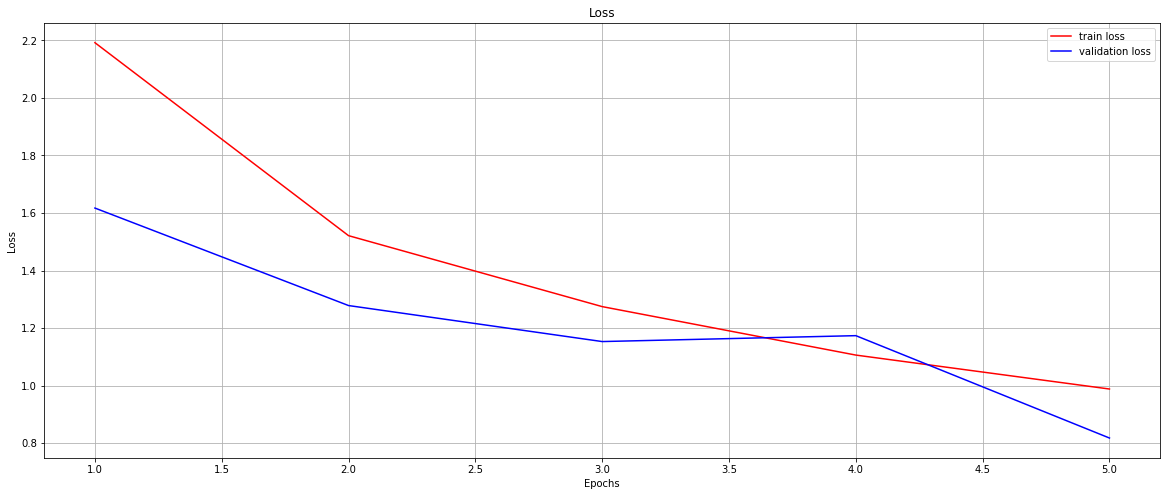

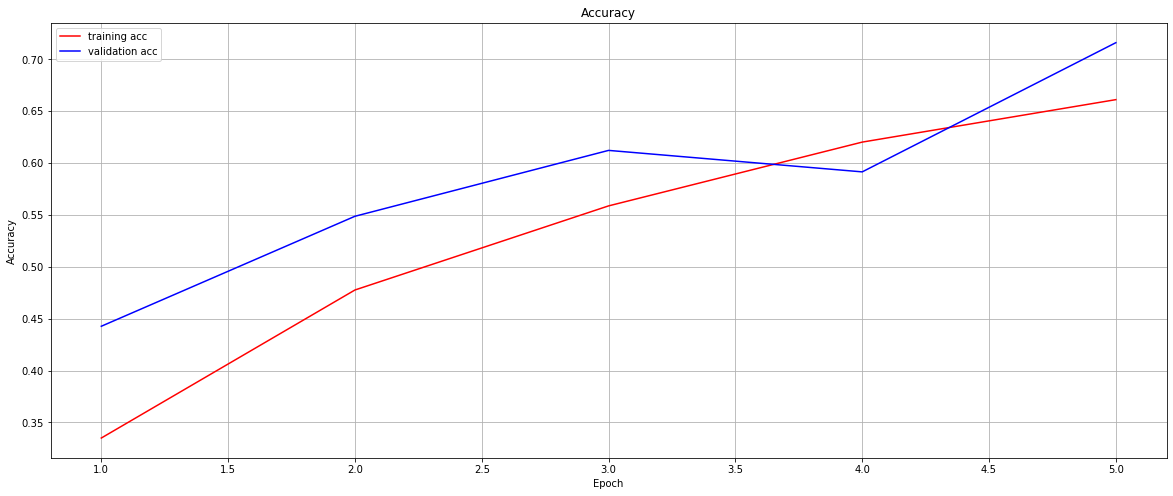

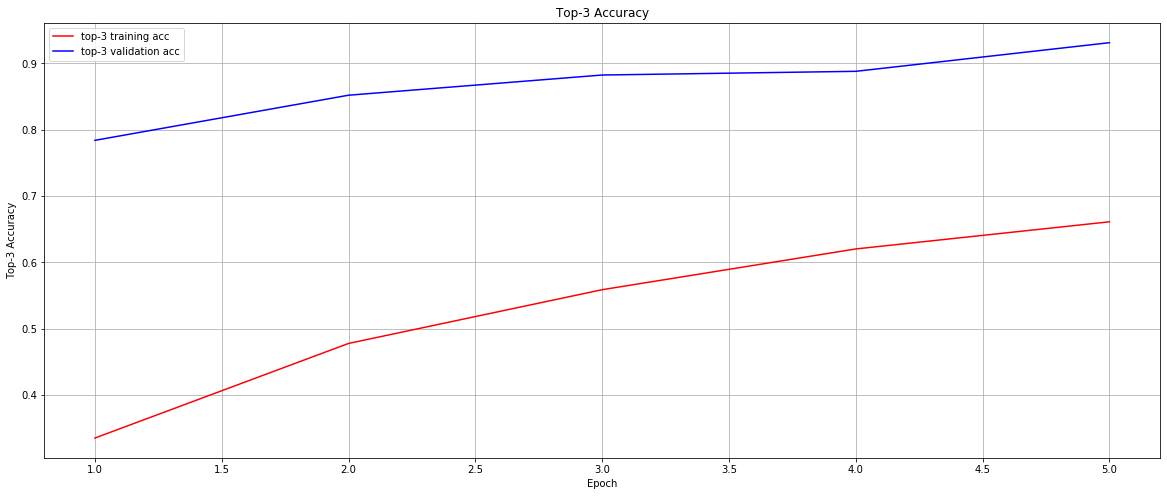

In [ ]:
# plot the train and validation losses
fig1 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats['Epoch'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-r', label='train loss')
ax.plot(x, train_stats['Validation loss'].values, '-b', label='validation loss')
plt.legend()
plt.grid()


# plot the train and validation accuracies
fig2 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

x = range(1, len(train_stats['Epoch'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-r', label='training acc')
ax.plot(x, train_stats['Validation accuracy'].values, '-b', label='validation acc')
plt.legend()
plt.grid()

# plot the train and validation top-3 accuracy
fig2 = plt.figure(figsize=(20,8))
ax = plt.axes()
plt.title("Top-3 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Top-3 Accuracy")

x = range(1, len(train_stats['Epoch'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-r', label='top-3 training acc')
ax.plot(x, train_stats['Validation top-3 accuracy'].values, '-b', label='top-3 validation acc')
plt.legend()
plt.grid()

## Testing the best parameters obtained

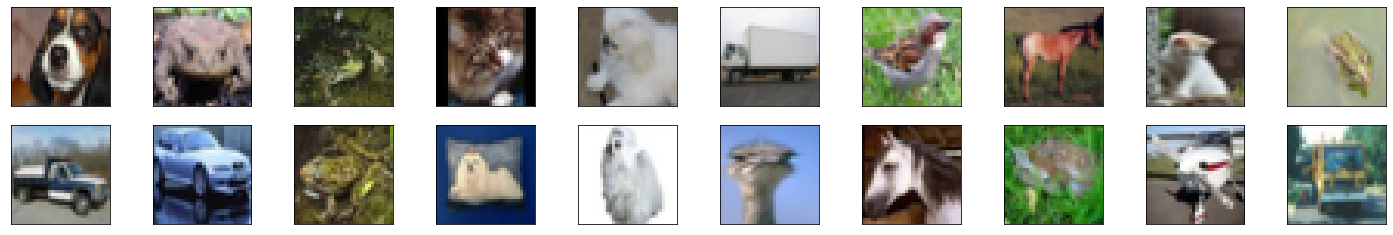

In [ ]:
# get a batch of test images
dataiterator = iter(test_loader)
images = dataiterator.next()
images = images.numpy() # convert images to numpy for display

# plot the iamges of the batch
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    showImage(images[i])

In [ ]:

# can we move the tensors to GPU?
# I evaluate the availability of cuda here again
# so that the user can use only this cell to predict the classes of
# the test images - provided there is a .pt file at hand (i.e. the .pt file
# containing the trained parameters) and that they are loaded to a similar
# DenseNet model as the model such parameters were trained (i.e. same mode architecture)

eval_modDN = DenseNet([12,18,16], tlayer="H_layer", k=32, nClasses=10)
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    eval_modDN.cuda()
    eval_modDN.load_state_dict(torch.load('modDN_SGD_trained.pt'))
else:
    eval_modDN.load_state_dict(torch.load('modDN_SGD_trained.pt',map_location=torch.device('cpu')))

# release the GPU memory
torch.cuda.empty_cache()

# set the DenseNet model for evaluation only
# (i.e. disabling dropouts during the forward pass)
eval_modDN.eval()

# numpy array to hold all the final predictions
# (i.e. the name of the class an image belongs to)
final_predictions = np.array([], dtype=str)

# draw batches of images from the test loader
# until all of them have been drawn
for image_batch in test_loader:
    if train_on_gpu:
                image_batch = image_batch.cuda()
    # get predictions of the classes of the iamges
    # on this batch
    mod_output = eval_modDN(image_batch)
    _, batch_pred = torch.max(mod_output, 1)
    final_predictions = np.append(final_predictions, [classes[x] for x in batch_pred])

# release the GPU memory
torch.cuda.empty_cache()

# prepare the submission of the predictions
sub = {'Id':[i for i in range(1, 1+len(x_test))], 'Category':final_predictions}
submission = pd.DataFrame(sub, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=True, header=True)

Compression factor smaller than 1.0 is exclusive of DenseNet BC.
Compression factor has been set to 1.0


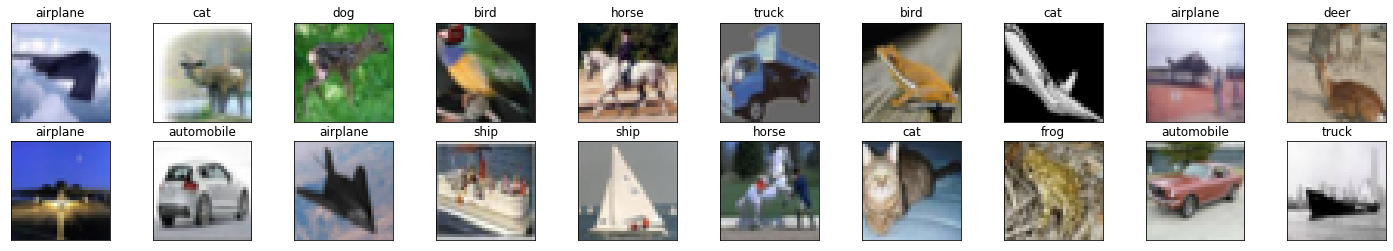

In [ ]:
# get 20 random indexes
indexes = np.random.randint(len(test_loader), size=20)

prediction_sample_batch = torch.Tensor()
# get a test image corresponding to the random index recently drawn
for idx in indexes:
    prediction_sample_batch = torch.cat([prediction_sample_batch, x_test[idx].unsqueeze(0)],0)


if train_on_gpu:
    prediction_sample_batch = prediction_sample_batch.cuda()

mod_output = eval_modDN(prediction_sample_batch)
_, image_pred = torch.max(mod_output, 1)

fig = plt.figure(figsize=(25,4))
# get numpy images out of the images batch
images = prediction_sample_batch.cpu()
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    showImage(images[idx])
    ax.set_title('{}'.format(classes[image_pred[idx]]))